<a href="https://colab.research.google.com/github/ParthikB/encryption/blob/master/encryption_CIFAR100.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import time
from google.colab.patches import cv2_imshow
import cv2


if torch.cuda.is_available():
  device = torch.device('cuda:0')
  running = 'GPU'
else:
  device = torch.device('cpu')
  running = 'CPU'
print(f'Running on : {running}')

Running on : GPU


### Grabbing the Data

In [2]:
train = datasets.CIFAR100('/content/CIFAR100', train=True, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

test  = datasets.CIFAR100('/content/CIFAR100', train=False, download=True,
                      transform=transforms.Compose([transforms.ToTensor()]))

0it [00:00, ?it/s]

169009152it [00:04, 41395389.55it/s]                               


Extracting /content/CIFAR100/cifar-100-python.tar.gz to /content/CIFAR100
Files already downloaded and verified


## Creating the Dataset Tensor

In [0]:
BATCH_SIZE = 16
HEIGHT, WIDTH, CHANNELS = 32, 32, 3
TOTAL_PIXELS = HEIGHT*WIDTH*CHANNELS

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=True)

#### Viewing one Sample

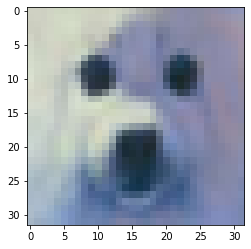

In [80]:
i = np.random.randint(10) # a random sample from the first batch
for data in trainSet:
    # data --> one batch containing BATCH_SIZE samples
    x, y = data[0][i].numpy(), data[1][i]

image = np.rollaxis(x, 0, 3)

plt.imshow(image) # Reshaping x from (1, Height, Width) --> (Height, Width)

## Creating the Network Structure

In [0]:
ENCRYPTED_DIM  = 16
ENCRYPTED_SIZE = ENCRYPTED_DIM * ENCRYPTED_DIM * CHANNELS
LAST_LAYER_INPUT_SIZE = ENCRYPTED_SIZE

class Net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(TOTAL_PIXELS   , ENCRYPTED_SIZE)
        self.fc2 = nn.Linear(ENCRYPTED_SIZE , ENCRYPTED_SIZE)

        self.fc3 = nn.Linear(ENCRYPTED_SIZE , ENCRYPTED_SIZE)

        self.fc4 = nn.Linear(ENCRYPTED_SIZE , ENCRYPTED_SIZE)        
        self.fc5 = nn.Linear(ENCRYPTED_SIZE , TOTAL_PIXELS)        
    
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))        
        x3 = F.sigmoid(self.fc3(x))
        x = F.sigmoid(self.fc4(x3))        
        x = F.sigmoid(self.fc5(x))        

        
        return x, x3

## Load Pretrained Model

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# Defining the Network and Optimizer base
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Loading the model file
model_state_path = '/content/drive/My Drive/Colab Notebooks/encryption/CIFAR100_model_state_1575276767__0.0138238'
model_state = torch.load(model_state_path)

# Transferring the Model States to respective variables
net.load_state_dict(model_state['state_dict'])
optimizer.load_state_dict(model_state['optimizer'])
loss_log = model_state['loss_log']

# Plotting the Loss
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

print('Model Loaded!')

## Training the Network

  0%|          | 0/3125 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
  1%|          | 25/3125 [00:00<00:12, 242.69it/s]



EPOCH : 1


  1%|          | 25/3125 [00:00<00:12, 243.73it/s]



EPOCH : 2
Current Loss : 0.012789820320904255


  1%|          | 23/3125 [00:00<00:13, 227.05it/s]



EPOCH : 3
Current Loss : 0.019419852644205093


  1%|          | 26/3125 [00:00<00:12, 253.11it/s]



EPOCH : 4
Current Loss : 0.013425417244434357


  1%|          | 20/3125 [00:00<00:16, 189.55it/s]



EPOCH : 5
Current Loss : 0.019151432439684868


  1%|          | 25/3125 [00:00<00:12, 244.71it/s]



EPOCH : 6
Current Loss : 0.011689943261444569


  1%|          | 24/3125 [00:00<00:13, 236.87it/s]



EPOCH : 7
Current Loss : 0.014028739184141159


  1%|          | 23/3125 [00:00<00:13, 228.83it/s]



EPOCH : 8
Current Loss : 0.015434754081070423


  1%|          | 26/3125 [00:00<00:12, 254.79it/s]



EPOCH : 9
Current Loss : 0.010247076861560345


  1%|          | 23/3125 [00:00<00:13, 227.89it/s]



EPOCH : 10
Current Loss : 0.01341298222541809


100%|██████████| 3125/3125 [00:12<00:00, 242.86it/s]


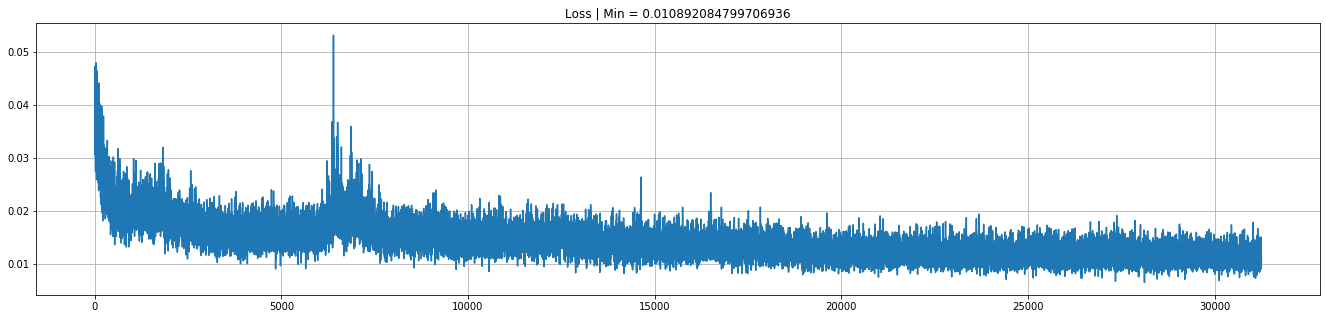

In [73]:
CONTINUE_TRAINING = False
LEARNING_RATE = 0.001 #1e-3
EPOCHS        = 10

if not CONTINUE_TRAINING:
  net = Net().to(device)

  # Define Optimizer
  optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

  loss_log = []

# Iteration Begins
for epoch in range(EPOCHS):
    print() ; print();
    print('EPOCH :', epoch+1)
    if loss_log:
      print('Current Loss :', loss_log[-1].item())
    # Iterate over every sample in the batch
    for data in tqdm(trainSet):
        x, _ = data
        net.zero_grad()
        
        #Compute the output
        output, layer2 = net(x.view(-1, TOTAL_PIXELS).to(device))
        
        # Compute Loss
        loss = F.smooth_l1_loss(output, x.view(-1, TOTAL_PIXELS).to(device))
        loss_log.append(loss)
        
        # Backpropagate
        loss.backward()
        
        # Update Parameters
        optimizer.step()
        

plt.figure(figsize=(23, 5))
plt.plot(loss_log)
plt.title(f'Loss | Min = {loss_log[-1].item()}')
plt.grid(1)

## Encryption Decryption

In [0]:
# Function to Convert Tensor into Numpy Image
def convert_to_image(input, size=None, roll=False):
  if roll == True: # Rolling from Vector to Matrix
    input = input.view(CHANNELS, size, size)

  # Moving the Channel axis from (C, H, W) -> (H, W, C)
  img = np.rollaxis(input.numpy(), 0, 3)
  return img

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")



Total Loss : 0.010892084799706936


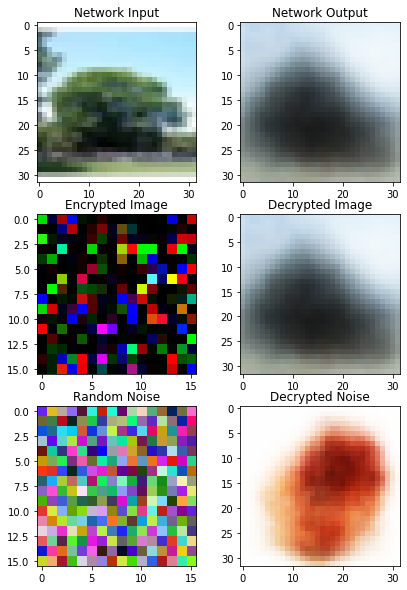

In [75]:
# Selecting a random sample from the dataset
random = np.random.randint(16)
for data in trainSet:
  # print(data)
  sample, y = data[0][i], data[1][i]
  break

# Converting the sample into an Image to plot later.
inputImage = convert_to_image(sample)

# Passing the sample through the Network and also generating the ENCRYPTED VECTOR
with torch.no_grad():
  networkOutput, encryptedImage = net(sample.view(-1, TOTAL_PIXELS).to(device))


# Converting the networkOutput tensor into Image (numpy array)
networkOutput  = networkOutput.cpu().detach()
networkOutput  = convert_to_image(networkOutput, size=HEIGHT, roll=True)

# Generating a random noise image to verify that ENCRYPTED VECTOR is just not random
randomNoise = torch.rand(ENCRYPTED_DIM, ENCRYPTED_DIM, CHANNELS).to(device)


# DECRYPTING THE ENCRYPTED_VECTOR and NOISE
with torch.no_grad():
  # Passing the ENCRYPTED VECTOR through the required layers of the Network.
  decryptedImage = F.sigmoid(net.fc4(encryptedImage.view(-1, ENCRYPTED_SIZE)))
  decryptedImage = F.sigmoid(net.fc5(decryptedImage.view(-1, LAST_LAYER_INPUT_SIZE)))

  # Passing the Random Noise Image through the required layers of the Network.
  randomNoiseDecrypted = F.sigmoid(net.fc4(randomNoise.view(-1, ENCRYPTED_SIZE)))
  randomNoiseDecrypted = F.sigmoid(net.fc5(randomNoiseDecrypted.view(-1, LAST_LAYER_INPUT_SIZE)))

# Converting the ENCRYPTED VECTOR into Image Format
encryptedImage  = encryptedImage.cpu().detach()
encryptedImage  = convert_to_image(encryptedImage, size=ENCRYPTED_DIM, roll=True)

# Converting the DECRYPTED VECTOR into Image Format
decryptedImage  = decryptedImage.cpu().detach()
decryptedImage  = convert_to_image(decryptedImage, size=HEIGHT, roll=True)

# Converting the Random Noise Decrypted Vector into Image Format
randomNoiseDecrypted  = randomNoiseDecrypted.cpu().detach()
randomNoiseDecrypted  = convert_to_image(randomNoiseDecrypted, size=HEIGHT, roll=True)


# PLOTTING THE OUTPUTS
plt.figure(figsize=(14, 10))

plt.subplot(3, 4, 1)
plt.imshow(inputImage)
plt.title('Network Input')

plt.subplot(3, 4, 2)
plt.imshow(networkOutput)
plt.title('Network Output')

plt.subplot(3, 4, 5)
plt.imshow(encryptedImage)
plt.title('Encrypted Image')

plt.subplot(3, 4, 6)
plt.imshow(decryptedImage)
plt.title('Decrypted Image')

plt.subplot(3, 4, 9)
plt.imshow(randomNoise.cpu())
plt.title('Random Noise')

plt.subplot(3, 4, 10)
plt.imshow(randomNoiseDecrypted)
plt.title('Decrypted Noise')

# # The Original Gray Images
# plt.subplot(3, 4, 3)
# plt.imshow(sample, cmap='gray')
# plt.title('Network Input')

# plt.subplot(3, 4, 4)
# plt.imshow(networkOutput, cmap='gray')
# plt.title('Network Output')

# plt.subplot(3, 4, 7)
# plt.imshow(encryptedImage, cmap='gray')
# plt.title('Encrypted Image')

# plt.subplot(3, 4, 8)
# plt.imshow(decryptedImage, cmap='gray')
# plt.title('Decrypted Image')

# plt.subplot(3, 4, 11)
# plt.imshow(randomNoise, cmap='gray')
# plt.title('Random Noise')

# plt.subplot(3, 4, 12)
# plt.imshow(randomNoiseDecrypted, cmap='gray')
# plt.title('Decrypted Noise')

print()
print("Total Loss :", loss_log[-1].item())

In [76]:
print('Difference between Network output and Decrypted Image :', np.sum(networkOutput - decryptedImage))

Difference between Network output and Decrypted Image : 0.0


In [77]:
SAVE_MODEL = True

if SAVE_MODEL:

  from google.colab import drive
  drive.mount('/content/drive')

  model_state = {
      'dataset'   : 'CIFAR100',
      'epochs'    : 10,
      'loss_type' : 'smooth_l1_loss',
      'loss_log'  : loss_log,
      'state_dict': net.state_dict(),
      'optimizer' : optimizer.state_dict(),
  }

  torch.save(model_state, f'/content/drive/My Drive/Colab Notebooks/encryption/' + model_state['dataset'] + f'_model_state_{int(time.time())}__{np.round(loss_log[-1].item(), 7)}')
  print(f'Model [' + model_state['dataset'] + f'_model_state_{int(time.time())}__{np.round(loss_log[-1].item(), 7)}] saved successfully!')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model [CIFAR100_model_state_1575284407__0.0108921] saved successfully!


# Accuracy Check (Not yet Implemeted)

In [0]:
BATCH_SIZE = 1

trainSet = torch.utils.data.DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
testSet  = torch.utils.data.DataLoader(test,  batch_size=BATCH_SIZE, shuffle=False)

In [0]:
outputs = []

with torch.no_grad():
    for data in tqdm(trainSet):
        x, y = data
        # print(data)
        # break
        testOutput, encryptedImage = net(x.view(-1, TOTAL_PIXELS).to(device))

        # Because Decrypted Image = testOutput. So, to save time, we'll just use the testOutput for verification.
        outputs.append(testOutput.view(BATCH_SIZE, HEIGHT, WIDTH))

  0%|          | 0/60000 [00:00<?, ?it/s]/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
100%|██████████| 60000/60000 [00:36<00:00, 1666.21it/s]


In [0]:
input_unrolled_size = TOTAL_PIXELS
total_classes       = 10

class Classifier_net(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(input_unrolled_size, 64)
        self.fc2 = nn.Linear(64,    64)        
        self.fc3 = nn.Linear(64,    64)        
        self.fc4 = nn.Linear(64,    total_classes)        
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))        
        x = F.relu(self.fc3(x))        
        x = F.log_softmax(self.fc4(x), dim=1)
        
        return x

## Loading Pretrained Model

Model Loaded!


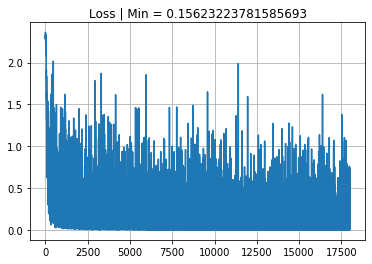

In [0]:
# Defining the Network and Optimizer base
classifier_net = Classifier_net().to(device)
optimizer = optim.Adam(classifier_net.parameters(), lr=0.001)

# Loading the model file
model_state_path = '/content/drive/My Drive/Colab Notebooks/encryption/classification_model'
model_state = torch.load(model_state_path)

# Transferring the Model States to respective variables
classifier_net.load_state_dict(model_state['state_dict'])
optimizer.load_state_dict(model_state['optimizer'])
classifier_loss_log = model_state['loss_log']

# Plotting the Loss
plt.plot(classifier_loss_log)
plt.title(f'Loss | Min = {classifier_loss_log[-1].item()}')
plt.grid(1)

print('Model Loaded!')

## Training the Network

tensor([5])


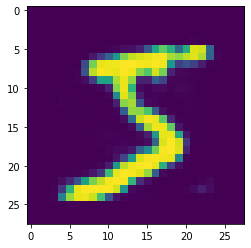

In [0]:
for data in zip(trainSet, outputs):
  # data.append(torch.rand(28, 28))
  # print(data)
  break

# plt.imshow(data[0][0].view(28,28))
plt.imshow(data[1].view(28,28).cpu())
print(data[0][1])

In [0]:
correct, total = 0, 0
decrypted_correct, decrypted_total = 0, 0

with torch.no_grad():
    
    # Train Accuracy
    for data in tqdm(zip(trainSet, outputs)):
        original, net_output = data
        x, y = original
        original_output  = classifier_net(x.view(-1, TOTAL_PIXELS).to(device))
        decrypted_output = classifier_net(net_output.view(-1, TOTAL_PIXELS).to(device))
        
        for idx, i in enumerate(original_output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        
        for idx, i in enumerate(decrypted_output):
            if torch.argmax(i) == y[idx]:
                decrypted_correct += 1
            decrypted_total += 1

    trainAccuracy = round(correct/total *100, 2)
    decrypted_trainAccuracy = round(decrypted_correct/decrypted_total *100, 2)
    
    # Test Accuracy
    for data in tqdm(zip(testSet, outputs)):
        original, net_output = data
        x, y = original
        original_output  = classifier_net(x.view(-1, TOTAL_PIXELS).to(device))
        decrypted_output = classifier_net(net_output.view(-1, TOTAL_PIXELS).to(device))
        
        for idx, i in enumerate(original_output):
            if torch.argmax(i) == y[idx]:
                correct += 1
            total += 1
        
        for idx, i in enumerate(decrypted_output):
            if torch.argmax(i) == y[idx]:
                decrypted_correct += 1
            decrypted_total += 1

    testAccuracy = round(correct/total *100, 2)
    decrypted_testAccuracy = round(decrypted_correct/decrypted_total *100, 2)

print()
print('Train Accuracy           :', trainAccuracy, '%')
print('Test Accuracy            :', testAccuracy, '%')
print('Decrypted Train Accuracy :', decrypted_trainAccuracy, '%')
print('Decrypted Test Accuracy  :', decrypted_testAccuracy, '%')

60000it [01:15, 789.92it/s]
10000it [00:12, 797.19it/s]


Train Accuracy           : 96.68 %
Test Accuracy            : 96.58 %
Decrypted Train Accuracy : 96.4 %
Decrypted Test Accuracy  : 84.05 %
